Test Data: https://drive.google.com/file/d/1KI5PjAL5u8v5wL0eAYe9gnQ4NDR3VPSq/view?usp=sharing   
Train Data: https://drive.google.com/file/d/11fW9mk_UWpFKsjYWoHDV9Cl-pbWvp6p9/view?usp=sharing

In [1]:
%pip install -U -q tensorflow-addons
%pip install -q huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.3 MB/s eta 0:00:00


In [2]:

import os
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, concatenate, Input
import tensorflow_addons as tfa

from huggingface_hub import hf_hub_download

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Mount google drive to push trained models

In [3]:
# Load the google drive

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/RVE_ML/"

Mounted at /content/drive


## Prepare the data

In [4]:
hf_hub_download(repo_id="dhruvindankhara/microstructure_RVE", filename="train_data.zip", repo_type="dataset", local_dir="train_data_repo/")

'train_data_repo/train_data.zip'

In [5]:
# Copies data from drive to the local working directory
!unzip -q "/content/train_data_repo/train_data.zip"

In [6]:
#------------------------------------------------------------------------------
#--------------------------------Load Data------------------------------
#------------------------------------------------------------------------------

# Images are loaded as filenames. Data pipe line will load the actual image.
# Properties are loaded in array
train_data = np.genfromtxt("train_data/micro_detail.csv", delimiter=",")

image_number = train_data[:,0].astype('int32') #image number

#List of image files
filename = []
for num in image_number:
  filename.append("train_data/plots/micro" + str(num) + ".png")

vol_frac = train_data[:,1] # Volume fraction in images
in_prop = train_data[:,6:8] # Properties of phase materials
out_prop = train_data[:,-4:] # Properties of RVE

In [7]:
#------------------------------------------------------------------------------
#--------------------------------Data Preparation------------------------------
#------------------------------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler

#Scaling the input modulus
input_mod_scaler = MinMaxScaler()
input_mod_scaler.fit(in_prop)
in_prop = input_mod_scaler.transform(in_prop)

#scaling the output modulus
output_mod_scaler = MinMaxScaler()
output_mod_scaler.fit(out_prop)
out_prop = output_mod_scaler.transform(out_prop)


In [8]:
#------------------------------------------------------------------------------
#--------------------------------Data Pipeline---------------------------------
#------------------------------------------------------------------------------
batch_size = 60

def parse_function(filename, in_prop, out_prop):
    """
    Loads the images and the material properties, performs preprocessing.

    Parameters
    ----------
    File name for the image

    """
    image = tf.image.decode_image(tf.io.read_file(filename))
    image = tf.image.crop_to_bounding_box(image, 0, 96, 752, 752)
    image = tf.image.convert_image_dtype(image[:,:,:3], tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    # Prepare a mask
    mask = image<0.9
    mask = tf.cast(mask, 'float32')
    # Apply mask to image
    image = tf.where(image>0.5, 1.0, 0.5) * mask
    return image, in_prop, out_prop

dataset = tf.data.Dataset.from_tensor_slices((filename, in_prop, out_prop))
dataset = dataset.shuffle(buffer_size=4)
dataset = dataset.map(parse_function, num_parallel_calls=4)
train_dataset = dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(2)

## Hyperparameters

In [9]:
num_epochs = 200

In [10]:
#-----------------------------------------------------------
#---------------------Network Start-------------------------
#-----------------------------------------------------------

cnnin = Input(shape=(752, 752, 1))
x = Conv2D(16, 3, padding = 'same', activation='relu')(cnnin)
x = MaxPooling2D((2,2))(x)
x = Conv2D(16, 3, padding = 'same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, 3, padding = 'same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, 3, padding = 'same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, 3, padding = 'same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, 3, padding = 'same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, 3, padding = 'same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, 3, padding = 'same', activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.1)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.1)(x)
cnnout = Dense(256, activation="relu")(x)
x = Dropout(0.1)(x)

cnnmodel= keras.Model(cnnin, cnnout, name="cnn_model")

mlpin = Input(shape=(2, ), name="mlp_input")
mlpout = Dense(64)(mlpin)

combinedout = concatenate([mlpout, cnnmodel.output])

x = Dense(512, activation="relu")(combinedout)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)
finalout = Dense(4)(x)

model = keras.Model( inputs=[mlpin, cnnin], outputs=[finalout])

In [ ]:
#-----------------------------------------------------------
#-------------------Prepare the Model-----------------------
#-----------------------------------------------------------
relu = tf.keras.layers.ReLU()
loss_fn = keras.losses.MeanSquaredError()

#@tf.function
def custom_loss(ypred, ytrue, in_prop):
    model_loss = loss_fn(ytrue, ypred)
    total_loss = model_loss
    return loss_fn(ytrue, ypred)


In [ ]:
#-----------------------------------------------------------
#------------------------Training---------------------------
#-----------------------------------------------------------

@tf.function
def grad(model, x, in_prop, out_prop):
  with tf.GradientTape() as tape:
      model_output = model([in_prop, x])
      loss_value = loss_fn(model_output, out_prop)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

@tf.function
def train_step(x, in_prop, out_prop):
      # Optimize the model
      loss_value, grads = grad(model, x, in_prop, out_prop)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      return loss_value

train_loss_results = []
start_time = time.time()

optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
num_epochs = 200

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    for step, (x, in_prop, out_prop)  in enumerate(train_dataset):
        loss_value = train_step(x, in_prop, out_prop)
        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # End epoch
    epoch_loss = epoch_loss_avg.result()
    train_loss_results.append(epoch_loss)
    if epoch % 1 == 0:
        print("Epoch {:03d}: Loss: {:.8f}".format(epoch, epoch_loss))

end_time = time.time()

print(f"Time take in training: {end_time - start_time} seconds")

Epoch 000: Loss: 0.05287817
Epoch 001: Loss: 0.01053014
Epoch 002: Loss: 0.01004441
Epoch 003: Loss: 0.00964811
Epoch 004: Loss: 0.00853789
Epoch 005: Loss: 0.00446842
Epoch 006: Loss: 0.00408056
Epoch 007: Loss: 0.00373161
Epoch 008: Loss: 0.00369327
Epoch 009: Loss: 0.00365409
Epoch 010: Loss: 0.00364431
Epoch 011: Loss: 0.00374248
Epoch 012: Loss: 0.00372688
Epoch 013: Loss: 0.00362253
Epoch 014: Loss: 0.00365938
Epoch 015: Loss: 0.00351199
Epoch 016: Loss: 0.00350766
Epoch 017: Loss: 0.00353071
Epoch 018: Loss: 0.00343604
Epoch 019: Loss: 0.00337618
Epoch 020: Loss: 0.00332927
Epoch 021: Loss: 0.00331039
Epoch 022: Loss: 0.00327810
Epoch 023: Loss: 0.00324568
Epoch 024: Loss: 0.00324997
Epoch 025: Loss: 0.00321177
Epoch 026: Loss: 0.00325676
Epoch 027: Loss: 0.00326538
Epoch 028: Loss: 0.00326263
Epoch 029: Loss: 0.00329354
Epoch 030: Loss: 0.00318530
Epoch 031: Loss: 0.00312033
Epoch 032: Loss: 0.00310114
Epoch 033: Loss: 0.00306615
Epoch 034: Loss: 0.00301407
Epoch 035: Loss: 0.0

In [ ]:
#Save the trained model NOTE: Change file name before running
model.save(path + 'CNN_02_sep_final.model')

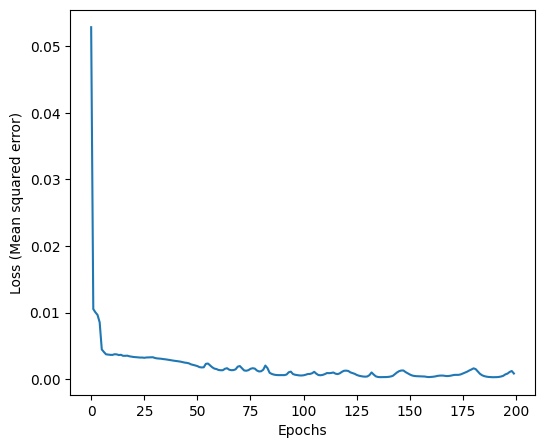

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(train_loss_results)
plt.xlabel("Epochs")
plt.ylabel("Loss (Mean squared error)")
plt.savefig('CNN_training.pdf')

## Plotting error on training set to make sure that model is not overfitting

In [ ]:
predictions = []
true = []
images = []
for x, in_prop, out_prop in train_dataset:
    pred = model([in_prop, x])
    true.append(out_prop)
    images.append(x)
    predictions.append(pred.numpy())

predictions = np.vstack(predictions)
true = np.vstack(true)

predictions = output_mod_scaler.inverse_transform(predictions)
#true = output_mod_scaler.inverse_transform(true)

error = np.divide(np.abs((predictions-true)), true) * 100

In [ ]:
x = error[:,0]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Test set percentage error - E11')
plt.xlabel('Percentage Error')

In [ ]:
x = error[:,1]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Test set percentage error - E22')
plt.xlabel('Percentage Error')

In [ ]:
x = error[:,2]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Test set percentage error - mu1')
plt.xlabel('Percentage Error')

In [ ]:
x = error[:,3]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Test set percentage error - mu2')
plt.xlabel('Percentage Error')

## Testing

### Load test data

In [ ]:
hf_hub_download(repo_id="dhruvindankhara/microstructure_RVE", filename="test_data.zip", repo_type="dataset", local_dir="test_data_repo/")
# Copies data from drive to the local working directory
!unzip -q "/content/test_data_repo/test_data.zip"

In [ ]:
test_data = np.genfromtxt("test_data/micro_detail.csv", delimiter=",")

test_image_number = test_data[:,0].astype('int32') #image number

#List of image files
test_filename = []
for num in test_image_number:
  test_filename.append("test_data/plots/micro" + str(num) + ".png")

test_vol_frac = test_data[:,1] # Volume fraction in images
test_in_prop = test_data[:,6:8] # Properties of phase materials
test_out_prop = test_data[:,-4:] # Properties of RVE

In [ ]:
test_in_prop = input_mod_scaler.transform(test_in_prop)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_filename, test_in_prop, test_out_prop))
test_dataset = test_dataset.map(parse_function, num_parallel_calls=4)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(2)

In [ ]:
#Testing one batch
predictions = []
true = []
images = []
for x, in_prop, out_prop in test_dataset:
    pred = model([in_prop, x])
    true.append(out_prop)
    images.append(x)
    predictions.append(pred)
    break

predictions = output_mod_scaler.inverse_transform(predictions[0])
#true = output_mod_scaler.inverse_transform(true[0])

error = np.divide(np.abs((predictions-true[0])), true[0]) * 100

In [ ]:
np.mean(error, axis=0)

array([3.98958316, 3.55774207, 6.2875033 , 4.65388827])

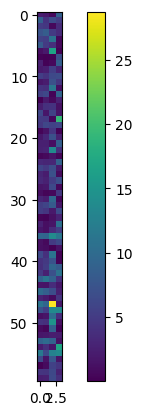

In [ ]:
plt.imshow(error)
plt.colorbar()

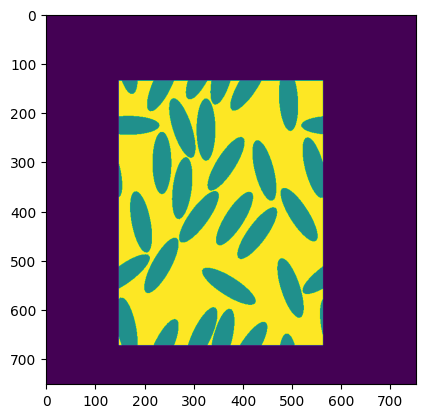

In [ ]:
plt.imshow(images[0][41])

## All test results

In [ ]:
predictions = []
true = []
images = []
for x, in_prop, out_prop in test_dataset:
    pred = model([in_prop, x])
    true.append(out_prop)
    images.append(x)
    predictions.append(pred.numpy())

predictions = np.vstack(predictions)
true = np.vstack(true)

predictions = output_mod_scaler.inverse_transform(predictions)
#true = output_mod_scaler.inverse_transform(true)

error = np.divide(np.abs((predictions-true)), true) * 100

In [ ]:
from sklearn import metrics

In [ ]:
i=3
metrics.r2_score(true[:,i], predictions[:,i])

0.1546651109200473

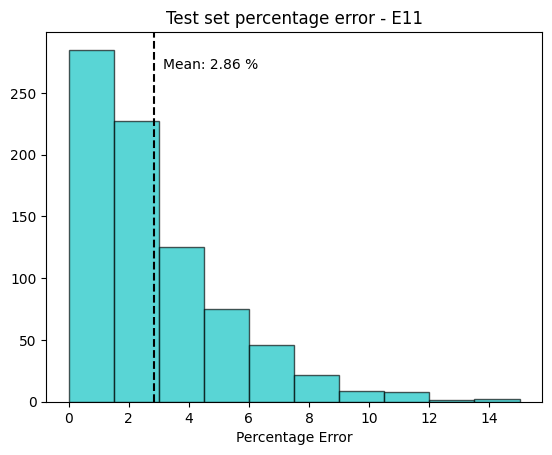

In [ ]:
x = error[:,0]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Test set percentage error - E11')
plt.xlabel('Percentage Error')

plt.savefig("CNN_error_1.pdf")

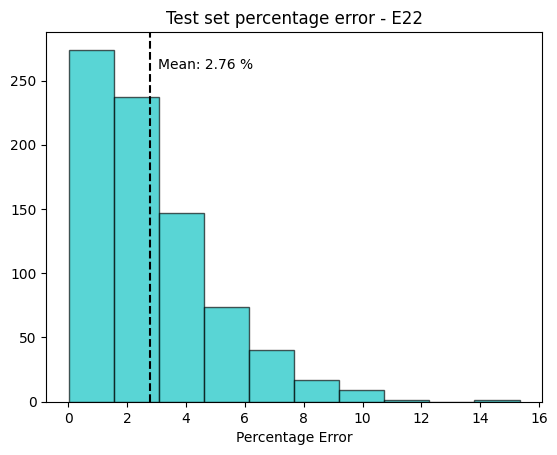

In [ ]:
x = error[:,1]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Test set percentage error - E22')
plt.xlabel('Percentage Error')
plt.savefig("CNN_error_2.pdf")

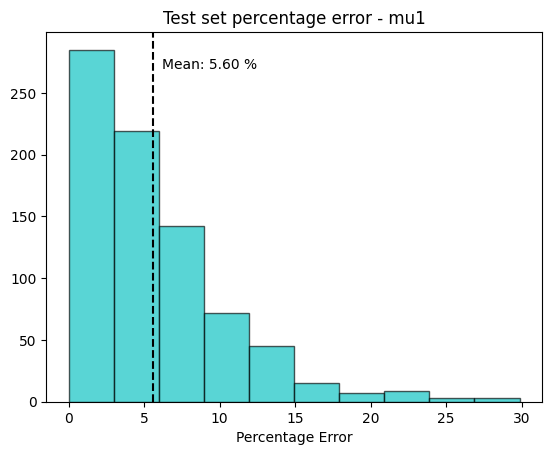

In [ ]:
x = error[:,2]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Test set percentage error - mu1')
plt.xlabel('Percentage Error')
plt.savefig("CNN_error_3.pdf")

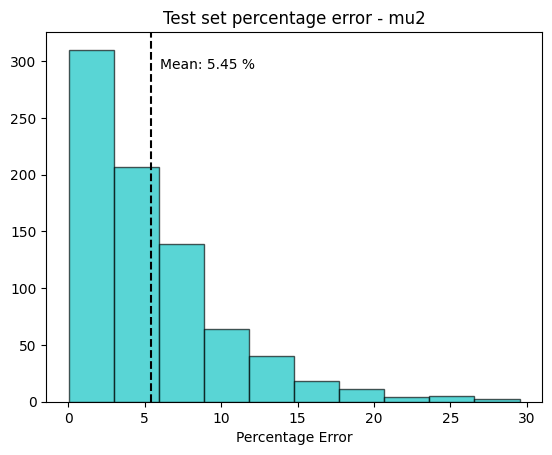

In [ ]:
x = error[:,3]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Test set percentage error - mu2')
plt.xlabel('Percentage Error')
plt.savefig("CNN_error_4.pdf")

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 752, 752, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 752, 752, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 376, 376, 16  0           ['conv2d[0][0]']                 
                                )                                                             